The purpose of this script is to compute and store the data 
necessary to develop an insertion frequency estimate of
L1 elements in various known human tumor suppressor genes 
based on the Snap-Velcro model of Monot et al. 2013. The hg38 
reference is used to gather this data.

In [99]:
#--- Load necessary libraries
library(data.table)
library(BSgenome.Hsapiens.UCSC.hg38)
library(GenomicRanges)
library(plyr)
options(warn=1) # print any warnings
colscheme = c("deeppink","darkgreen","dodgerblue","grey")

A tab-delimited file is read from the web to a table. The file is made available by the TSGene 2.0 database project and contains data on 983 human tumor suppressor genes which are down-regulated in tumor samples versus normal tissue.

In [3]:
tsg_table <- fread("https://bioinfo.uth.edu/TSGene/All_down_exp_TSGs_pan-cancer.txt")
head(tsg_table)

GeneID,GeneName,NumberOfCancers,CancerTypes
9590,AKAP12,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
8854,ALDH1A2,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
84417,C2orf40,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
8434,RECK,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
8031,NCOA4,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
79633,FAT4,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"


Get a list of TSG names from the table

In [4]:
head(tsg_table$GeneName)

[1] "AKAP12"  "ALDH1A2" "C2orf40" "RECK"    "NCOA4"   "FAT4"

Call a .gff3 file for hg38 stored locally, and extract genomic ranges of tumor suppressor genes

In [5]:
system(paste0("grep ID=gene ../Data/humangenome/Homo_sapiens.GRCh38.89.gff3 > tmp"))
geneann <- fread("tmp") # extract all lines from .gff3 describing genes into a table
system("rm tmp")
cat("Gene list from hg38 .gff3 file")
names(geneann) <- c('chrom','source','type','start','end','score','strand','phase','attributes')
head(geneann)

Gene list from hg38 .gff3 file

chrom,source,type,start,end,score,strand,phase,attributes
1,havana,gene,11869,14409,.,+,.,ID=gene:ENSG00000223972;Name=DDX11L1;biotype=transcribed_unprocessed_pseudogene;description=DEAD/H-box helicase 11 like 1 [Source:HGNC Symbol%3BAcc:HGNC:37102];gene_id=ENSG00000223972;logic_name=havana;version=5
1,havana,gene,14404,29570,.,-,.,ID=gene:ENSG00000227232;Name=WASH7P;biotype=unprocessed_pseudogene;description=WAS protein family homolog 7 pseudogene [Source:HGNC Symbol%3BAcc:HGNC:38034];gene_id=ENSG00000227232;logic_name=havana;version=5
1,mirbase,miRNA_gene,17369,17436,.,-,.,ID=gene:ENSG00000278267;Name=MIR6859-1;biotype=miRNA;description=microRNA 6859-1 [Source:HGNC Symbol%3BAcc:HGNC:50039];gene_id=ENSG00000278267;logic_name=ncrna;version=1
1,havana,lincRNA_gene,29554,31109,.,+,.,ID=gene:ENSG00000243485;Name=MIR1302-2HG;biotype=lincRNA;description=MIR1302-2 host gene [Source:HGNC Symbol%3BAcc:HGNC:52482];gene_id=ENSG00000243485;logic_name=havana;version=5
1,mirbase,miRNA_gene,30366,30503,.,+,.,ID=gene:ENSG00000284332;Name=MIR1302-2;biotype=miRNA;description=microRNA 1302-2 [Source:HGNC Symbol%3BAcc:HGNC:35294];gene_id=ENSG00000284332;logic_name=ncrna;version=1
1,havana,lincRNA_gene,34554,36081,.,-,.,ID=gene:ENSG00000237613;Name=FAM138A;biotype=lincRNA;description=family with sequence similarity 138 member A [Source:HGNC Symbol%3BAcc:HGNC:32334];gene_id=ENSG00000237613;logic_name=havana;version=2


In [6]:
j=1;
tsg_inds<-rep(0,nrow(tsg_table)) # allocate memory for array of TSG indices in the list of genes
for (i in tsg_table$GeneName){
        tmp <- grep(paste0("Name=",i,";"),geneann$attributes) # search for "Name=<gene name>" in the attributes column of the .gff3
        if (length(tmp)==0){ # if it was not found, place a NA for index of the current TSG
                tsg_inds[j]=NA;
        } else { # if found, store its index in the list
                tsg_inds[j] <- tmp
        }
        j<-j+1 # increment tsg_inds array counter
        # print(grep(paste0("Name=",i,";"),geneann$V9)) # print to screen the index of the current TSG (not necessary)
}
tsgann <- geneann[tsg_inds] # extract rows of the geneann table associated with TSGs
tsgann <- tsgann[,c("chrom","start","end")] # extract columns describing genomic ranges (chrom name, start, end)

Warning message in tsg_inds[j] <- tmp:
“number of items to replace is not a multiple of replacement length”Warning message in tsg_inds[j] <- tmp:
“number of items to replace is not a multiple of replacement length”

In [7]:
tsgann=tsgann[which(!is.na(tsgann$chrom))]
cat("Genomic ranges of TSGs")
head(tsgann)
cat(paste0(nrow(tsgann),"/",nrow(tsg_table)," TSGs from the database were located in hg38.\n"))

Genomic ranges of TSGs

chrom,start,end
6,151239999,151358557
15,57953424,58497866
2,106063246,106078159
9,36036433,36124451
10,46005088,46030714
4,125316399,125492932


971/983 TSGs from the database were located in hg38.


We will now count the number of sites of each SV site category within the TSGs, as well as in hg38 overall. TSG densities are also stored.

In [8]:
chr_tsg_counts <-  array(0,dim=c(24,9)) # Allocate memory

#--- Loop through chromosome names
j<-1
for (i in names(Hsapiens)[1:24]){

        # cat("\nProccessing ",i,"...")
        load(paste0("../Data/root_maps/",i,"map.rda")) # Load map file for current chromosome

        # Data objects containing indices of S-V sites for each category are labeled with the chromosome name.
        # Here we copy the data objects to a set of generic names which can be used consistently in the following
        # code. 
        ict<-get(paste0(i,"ict"))
        icl<-get(paste0(i,"icl"))
        iot<-get(paste0(i,"iot"))
        iol<-get(paste0(i,"iol"))
        insites<-get(paste0(i,"insites"))

        # Extract TSG regions for the current chromosome
        chrno<-strsplit(i,"chr")[[1]][2] # Get the current chromosome number (or letter)
        tsgann_i <- tsgann[tsgann$chrom == chrno,] # Extract a subset of the 'tsgann' table for regions in the current chromosome

        # Fill in columns 1-4 of the row of the chr_tsg_counts array corresponding to current chromosome.
        # These columns contain the number of sites of each S-V category lying within TSGs 
        # Categories are in this order: closed-tight, closed-loose, open-tight, open-loose
        tmp<-inrange(insites[as.vector(ict[which(!is.na(ict))])],tsgann_i$start,tsgann_i$end) # Check if any Closed-Tight category sites are within the start-end range of tsgann_i
        chr_tsg_counts[j,1]<-length(which(tmp == TRUE))                                    # Fill an element of the chr_tsg_counts table with the count
        tmp<-inrange(insites[as.vector(icl[which(!is.na(icl))])],tsgann_i$start,tsgann_i$end)
        chr_tsg_counts[j,2]<-length(which(tmp == TRUE))
        tmp<-inrange(insites[as.vector(iot[which(!is.na(iot))])],tsgann_i$start,tsgann_i$end)
        chr_tsg_counts[j,3]<-length(which(tmp == TRUE))
        tmp<-inrange(insites[as.vector(iol[which(!is.na(iol))])],tsgann_i$start,tsgann_i$end)
        chr_tsg_counts[j,4]<-length(which(tmp == TRUE))

        # Fill in columns 5-8 of the row of the chr_tsg_counts array corresponding to current chromosome.
        # These columns contain the total number of sites of each category.
        chr_tsg_counts[j,5]<-length(which(!is.na(ict)))
        chr_tsg_counts[j,6]<-length(which(!is.na(icl)))
        chr_tsg_counts[j,7]<-length(which(!is.na(iot)))
        chr_tsg_counts[j,8]<-length(which(!is.na(iol)))

        # The last column contains the TSG fraction of the current chromosome
        tmp<-IRanges(tsgann_i$start,tsgann_i$end)
        chr_tsg_counts[j,9] <- sum(width(tmp))/length(Hsapiens[[i]])

        j<-j+1
}

In [9]:
colnames(chr_tsg_counts)<-c('CT_TSG','CL_TSG','OT_TSG','OL_TSG','CT_hg38','CL_hg38','OT_hg38','OL_hg38','TSG_frac')
# rownames(tsg_counts)<-tsgs[!is.na(tsg_inds)]
rownames(chr_tsg_counts)<-names(Hsapiens)[1:24]
head(chr_tsg_counts)

,CT_TSG,CL_TSG,OT_TSG,OL_TSG,CT_hg38,CL_hg38,OT_hg38,OL_hg38,TSG_frac
chr1,80966,113339,276312,762355,2672539,4201065,10488523,27971014,0.02721808
chr2,101775,178535,437165,1172829,2787188,4764698,11780898,30898470,0.03602919
chr3,166131,294210,721514,1913074,2313360,3998896,9894819,25986494,0.07373505
chr4,55157,103260,250323,658706,2239602,4069581,10206083,26038352,0.02578945
chr5,43331,72885,173268,476642,2091044,3680652,9108378,23951693,0.02218732
chr6,71885,116412,282684,737667,2002773,3464330,8609574,22339159,0.03430513


Here we apply the enrichment observed by Monot et al. to the counts

In [10]:
chr_tsg_enrich <- chr_tsg_counts[,1:4]
chr_tsg_enrich <- t( t(chr_tsg_enrich) * c(11.55,7.95,1.25,1.00) )
head(chr_tsg_enrich)

,CT_TSG,CL_TSG,OT_TSG,OL_TSG
chr1,935157.3,901045.1,345390.0,762355
chr2,1175501.2,1419353.2,546456.2,1172829
chr3,1918813.1,2338969.5,901892.5,1913074
chr4,637063.4,820917.0,312903.8,658706
chr5,500473.1,579435.8,216585.0,476642
chr6,830271.8,925475.4,353355.0,737667


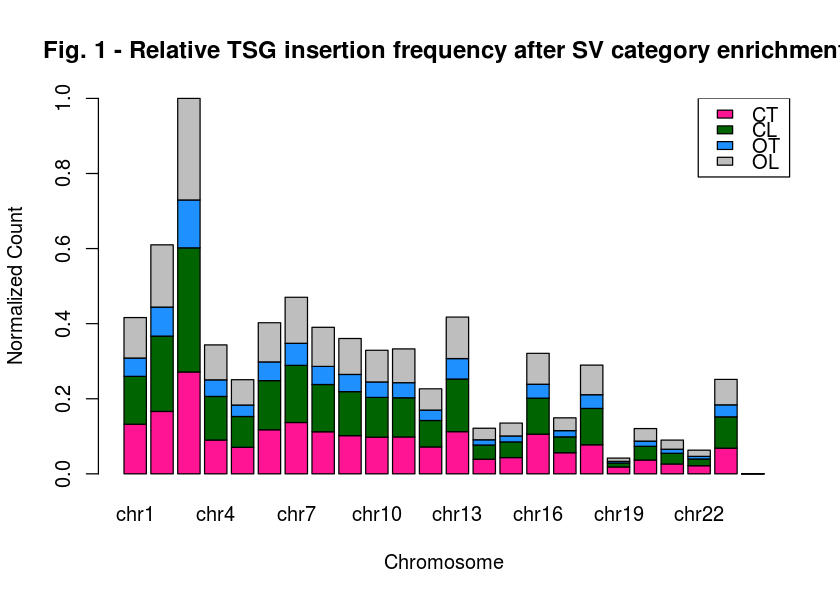

In [101]:
barplot(t(chr_tsg_enrich/max(rowSums(chr_tsg_enrich))),col=colscheme,ylab=" Normalized Count",xlab="Chromosome")
legend("topright",  fill=colscheme, c("CT","CL","OT","OL")  );
title("Fig. 1 - Relative TSG insertion frequency after SV category enrichment")
options(repr.plot.width=7, repr.plot.height=5)

For each chromosome, the number of sites of each SV category were counted. The counts for each site class were multiplied by the respective enrichment factor of the class, as determined by Monot et al. A significant spike in the normalized frequency is seen for chromosome 3. This suggests chromosome 3 is a hazard zone for TSG disruption by L1 activity.

In [12]:
tsgden<-rep(0,24)
for (i in 1:24){
    chrno<-strsplit(names(Hsapiens)[i],"chr")[[1]][2]
    chrmlen <- length(Hsapiens[[i]])
    tsgden[i] <- length(which(tsgann$chrom==chrno))/chrmlen
}
names(tsgden)=names(Hsapiens)[1:24]

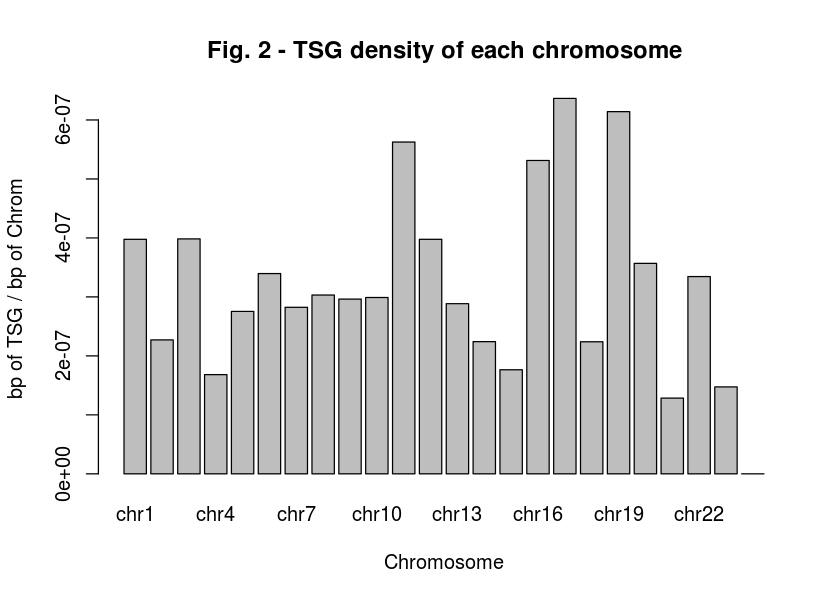

In [85]:
barplot(tsgden,ylab="bp of TSG / bp of Chrom",xlab="Chromosome",col="grey")
title("Fig. 2 - TSG density of each chromosome")
options(repr.plot.width=7, repr.plot.height=5)

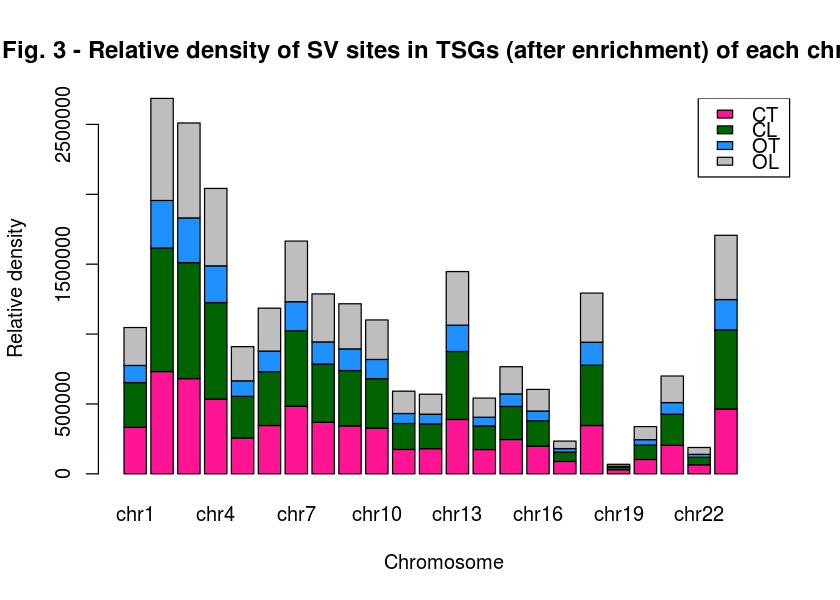

In [102]:
barplot(t(chr_tsg_enrich/(max(rowSums(chr_tsg_enrich))*tsgden)),col=colscheme,ylab="Relative density",xlab="Chromosome")
legend("topright",  fill=colscheme, c("CT","CL","OT","OL")  );
title("Fig. 3 - Relative density of SV sites in TSGs (after enrichment) of each chrom.")
options(repr.plot.width=7, repr.plot.height=5)

For the plot above, the values from Fig. 1 were further normalized (divided) by the chromosome TSG densities (Fig. 2), to reveal the relative density of SV sites of TSGs within each chromosome.

Above we can see that the TSGs of chromosomes 2,3,4 are dense with endonuclease sites. However, as shown in Fig. 2, chromosomes 2 and 4 contain less TSG region than chromosome 3. The moderate TSG density and high SV density of TSGs make chromosome 3 a likely place for an L1 to interfere with a TSG.

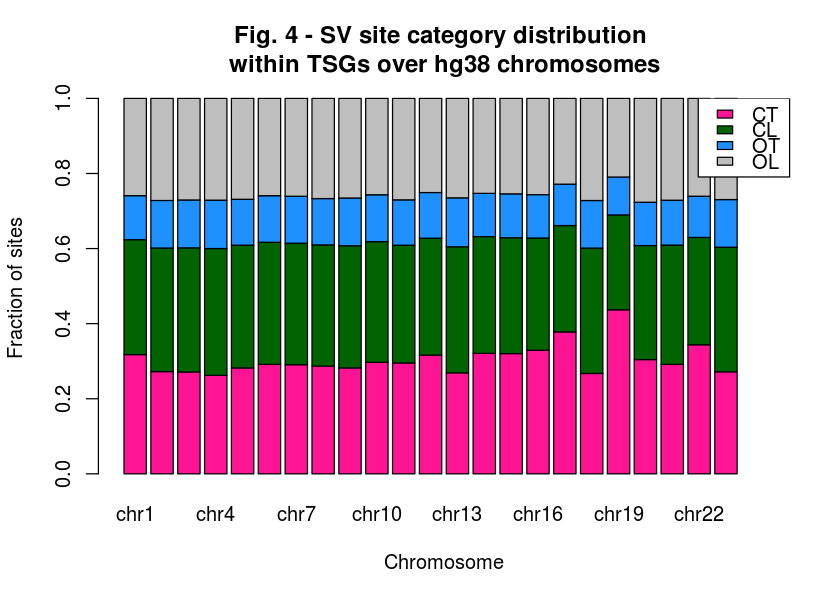

In [103]:
tsg_sv_dist = chr_tsg_enrich/rowSums(chr_tsg_enrich)
barplot(t(tsg_sv_dist),col=colscheme,ylab="Fraction of sites",xlab="Chromosome")
legend("topright",  fill=colscheme, c("CT","CL","OT","OL")  );
title("Fig. 4 - SV site category distribution 
within TSGs over hg38 chromosomes")
options(repr.plot.width=7, repr.plot.height=5)

The distribution of SV site classes amongst the TSGs of each chromosomes appears to contain no significant outliers.

In [16]:
gr <- GRanges(paste0("chr",tsgann$chrom),IRanges(tsgann$start,tsgann$end))
tsgs <- getSeq(Hsapiens,gr)
tsgs

  A DNAStringSet instance of length 971
        width seq
  [1]  118559 GGGACTCGGACTCGCTCCTGGGCGAGCTGAAA...TCTAATTAAATGCCATGGATTTTCTTTCTGT
  [2]  544443 AGGAGTACACAATATAAATGCTTTATTGCTAG...CTTGCCATGGAGCCAATGGAGCTTAGGTGTC
  [3]   14914 AAGAAGGTGCCATCTAGGAAGCAGGAAGCAGG...AAATAAAGCATTTTGTTAAAAAGAAAAGTCT
  [4]   88019 GATGAACCCTTGTCAGGGGGCCGTGTCTGCGG...TTTCTATTTTAATAAAAATAATTTTTATATG
  [5]   25627 TATGGCTGTTATGCTTTTAATGGAAGCAGATA...CGGGTCAGCCAGAAGCCCTTGACTGCCCTCT
  ...     ... ...
[967]   54680 CCAGGTTCCATCAGGTTTTTAATTGTACATCA...GAGAGGGGAGGACGGATCTGGCTGGCGGAAG
[968]    4416 TTTTGTTTGCTCTGAATTTATTGCGAGTGAAA...CCTCCTCTCCCTCCCTAGCTTTCTGTCTCCT
[969]    9003 GAAATCTGGAAAGCTCATTTATCTCTTTTTCT...TTCCTGAGAAATACAACCGGAAGCAAATTGC
[970]   10766 ATTGGCTAGGCCAGGGCGCCTGCGCGGCGGGG...AACTTGGGGCAATTTGCAGTTTGGAAACCTG
[971]    6016 AACGCGGGAAGCAGGGGCGGGGCCTCTGGTGG...AGCTCATTAAAAAAATGTGCCTAGTTTTATA

In [17]:
source("mapSeq_SV.r")
tsg_counts <-  array(0,dim=c(nrow(tsgann),4)) # Allocate memory
for (i in 1:nrow(tsgann)){
    tmp <- mapSeq_SV(tsgs[[i]])
    tsg_counts[i,]=c(length(which(!is.na(tmp$ict))),length(which(!is.na(tmp$icl))),length(which(!is.na(tmp$iot))),length(which(!is.na(tmp$iol))))
}

,CT,CL,OT,OL
AKAP12,1865,2109,5245,12944
ALDH1A2,5363,10164,24271,68774
C2orf40,182,202,655,1443
RECK,1310,1845,4530,11447
NCOA4,291,517,1060,3266
FAT4,1917,4389,10566,27346


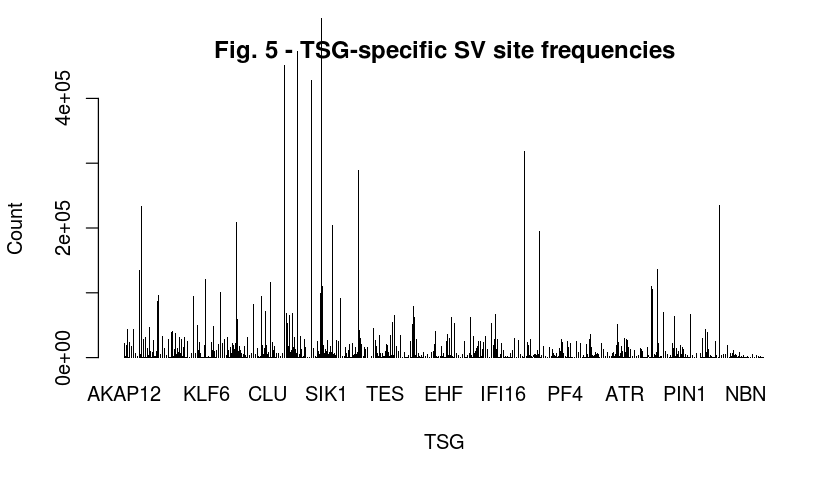

In [94]:
rownames(tsg_counts)<-tsg_table$GeneName[which(!is.na(tsg_inds))]
barplot(t(tsg_counts),col=c("black","black","black","black"),ylab="Count",xlab="TSG",border=NA,beside=FALSE,ylim=c(0,400000))
title("Fig. 5 - TSG-specific SV site frequencies")
options(repr.plot.width=7, repr.plot.height=4)
colnames(tsg_counts)<-c("CT","CL","OT","OL")
head(tsg_counts)

The above graph depicts the total count of SV sites in the analyzed TSGs. The site frequency varies greatly, with several TSGs showing high outlying spikes in site frequency.

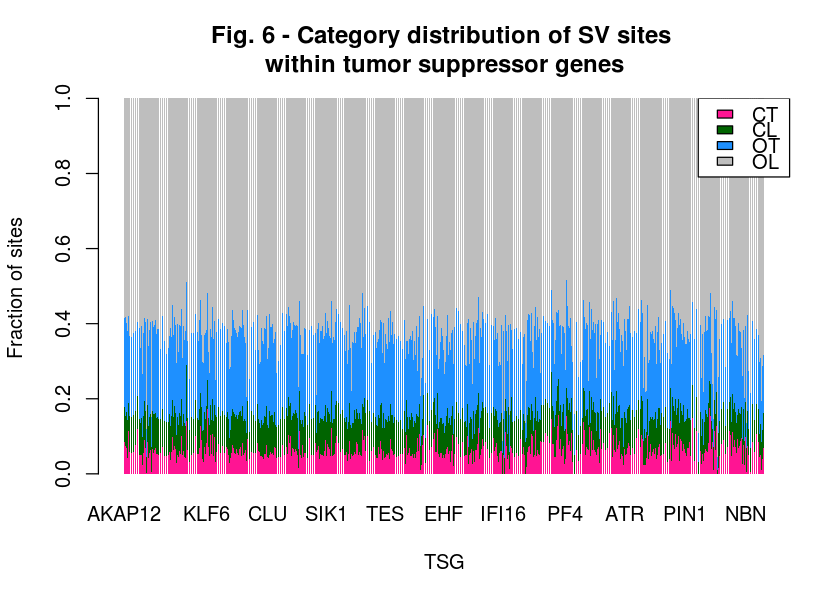

In [113]:
tsg_counts_norm = tsg_counts/rowSums(tsg_counts)
barplot(t(tsg_counts_norm),col=colscheme,ylab="Fraction of sites",xlab="TSG",border=NA)
legend("topright",  fill=colscheme, c("CT","CL","OT","OL")  );
title("Fig. 6 - Category distribution of SV sites 
within tumor suppressor genes")
options(repr.plot.width=7, repr.plot.height=5)

Although difficult to visualize without aliasing, the distribution of SV site classes appears to be reasonably consistent across the TSGs.

We will now focus on the APC gene.

In [39]:
tsg_table$GeneName[34]

[1] "APC"

In [38]:
quantile(width(tsgs), c(.87) )

87% 
190538.7

The length of APC gene is at approximately the 87th percentile of the lengths of TSGs located.

[1] "APC"

SV site category distribution in APC before and after enrichment

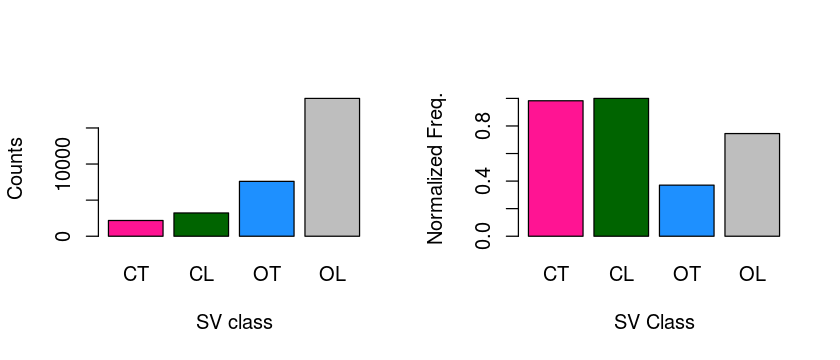

In [116]:
rownames(tsg_counts)[33]
par(mfrow=c(1,2))
cat("SV site category distribution in APC before and after enrichment")
barplot(tsg_counts[33,],ylab = "Counts",xlab="SV class",col=colscheme)
barplot(tsg_counts[33,]*c(11.55,7.95,1.25,1.00)/max(tsg_counts[33,]*c(11.55,7.95,1.25,1.00)),ylab="Normalized Freq.",xlab="SV Class",col=colscheme)
options(repr.plot.width=7, repr.plot.height=3)

In [74]:
nsites = rowSums(tsg_counts)
nsites[33]

APC 
32108

In [82]:
quantile(nsites,c(0.84))

84% 
30564.4

The APC gene is above the 84th percentile of the number of SV sites amongst the analyzed TSGs. This makes it a notably strong candidate site for L1 insertion.

Below we list the TSGs with a number of endonuclease sites within the 80th percentile.

In [109]:
nsites[nsites>quantile(nsites,c(0.80))]

ALDH1A2     FAT4   TGFBR3  SMARCA2   BMPR1A   MAPK10    PCDH9     LIFR 
  108572    44218    43862    44621    37929   134985   233317    28301 
     APC   RNF180     EYA4   SYNPO2    PRDM5  ZMYND11    SLIT2  L3MBTL4 
   32108    49010    67142    46946    54168    27497    87639    97260 
 TSC22D1    UNC5C    PIAS1  FAM172A   ZBTB16   SPTBN1    BMPR2     RARB 
   33700    87935    33966   117906    28685    40148    40287    87819 
   RAP1A     PTEN     RTN4    PRKCE    PBRM1     DDR2    NTRK3    RBMS3 
   37957    27016    31536    91618    29399    31106    63913   334027 
    GPC3    CADM2    SASH1    KANK1  EPB41L3    FOXO1    UNC5D    PACRG 
   94584   287101    53119    53967    50344    37031   121750   126130 
  RASSF8    ABCG2  STARD13    MCPH1     THRB     TCF4   MAP2K4  RPS6KA2 
   27517    28429    49071    47319    82149   100827    28608    80563 
   HACE1    MTUS1 CACNA2D3  PPP2R5C   RNF111     WWOX    PLCE1    LSAMP 
   30972    32130   180334    30112    50793   209945    59065   308093 
   SETD2   GRIN2A   RASSF3  RPS6KA6    FOXP1    SSBP2 ARHGEF12    PDS5B 
   31387    80130    35291    32325   128989    82700    35551    47049 
  PLA2R1    ERBB4    EPHA3    PPM1L     YAP1     DLC1     NUMB    KDM6A 
   28064   290324    94650    71392    27632   115956    39292    54433 
  TCF7L2      ST5    CSMD1    KMT2C    PTPRD   PTPN13    PDSS2    PRKCB 
   39621    37155   451218    68059   559459    53254    65543    68063 
   PPARG    LRP1B   NOTCH2      MME    SMAD2   CTNNA3    CADM1   TMEFF2 
   32541   473487    33067    36630    28344   427890    73594    59487 
    GPC5     ESR1      DMD   BRINP1    DACH1 PRICKLE1    PTPRT   IQGAP2 
  353978   100401   524219    42482   110076    27264   205019    62740 
   UBE4B   RASAL2    IFT88    UVRAG    SP100    ROBO1   HIVEP3      RB1 
   27136    91366    27616    72442    28634   288759    81550    43080 
   PTPRC  ADAMTS9     TET2     ROR2     NRF1    NEDD4      ATM    ZFHX3 
   30778    35592    32189    67899    29939    37895    33704    45561 
  MAP3K4      MCC   HIVEP1   PHLPP1    KIF1B   FBXL13   ZBTB7C    EFNA5 
   27804    90974    34466    57940    34636    55585    58423    64995 
    DLG1      DCC    DAPK1   CREBBP     CFTR     CDK6     CDH4   SRGAP3 
   62821   273918    35387    27876    58574    51537    80230    62915 
  RB1CC1 ARHGAP29    PTPRK    VPS53    DCDC2    OPCML    HIPK2    SGMS1 
   28686    28264   135341    34784    41220   213215    35585    68425 
  SMCHD1   CAMTA1     ZHX2     FHIT     EXT1   LMNTD1     CUX1    CDH13 
   36071   145547    30625   321909    63179    53585    71211   216409 
   MTSS1     TP63    CDC73    PTPRJ    FBXW7     PLD1    NPAS2      NF1 
   29631    61903    32572    32602    53359    46275    29012    67053 
    MTAP      FRK   NEDD4L    IKZF2     FAT1    EXTL3     ESR2    EPB41 
   28188    30322    65779    38278    27295    27926    50387    46376 
  CTNNA2   PLXNC1   INPP4B   MYO18B  PPP2R2C    ESRRB     RBM6    CDH11 
  318165    28465   195281    45059    29199    26885    29230    37092 
     ST7  SMARCC1    RBBP8      ATR     PAX5     PAWR  CNTNAP2     MCM9 
   58983    40138    51964    30019    28158    27665   525141    26806 
  POU6F2    EGLN3    DLEU1   TRIM24    RUNX2     ZIC1    RFWD2    NRCAM 
  109798   105727   136042    28440    69758    26671    64200    67101 
   GSK3B     EXT2     ETV6    ARID2 ADAMTS18    BASP1    DLEU2    RUNX1 
   64521    30803    44961    43836    38931    39988    33028   236148 
   NDST4     MSH2 
   71739    28214

In [111]:
length(nsites[nsites>quantile(nsites,c(0.80))])

[1] 194

194 TSGs lie above the 80th percentile of number of endonuclease sites.